# XGBoost - Extreme Gradient Boosting 

In [1]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: xgboost in c:\vs code\repository\venv\lib\site-packages (2.1.0)




[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Read the dataset

In [2]:
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
import pandas as pd
df = pd.read_csv('train_weather.csv')
df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


## Basic data quality checks 

In [4]:
df.isna().sum()

Temperature             0
Humidity                0
Wind Speed              0
Precipitation (%)       0
Cloud Cover             0
Atmospheric Pressure    0
UV Index                0
Season                  0
Visibility (km)         0
Location                0
Weather Type            0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
df['Weather Type'].unique()

array(['Rainy', 'Cloudy', 'Sunny', 'Snowy'], dtype=object)

## Separate X and Y (Weather type)

In [7]:
X = df.drop(columns=['Weather Type'])
Y = df[['Weather Type']]

In [8]:
X.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain


In [9]:
Y.head()

,Weather Type
0,Rainy
1,Cloudy
2,Sunny
3,Sunny
4,Rainy


## Apply preprocessing on X 

In [10]:
cat = list(X.columns[X.dtypes=='object'])
con = list(X.columns[X.dtypes!='object'])

In [11]:
cat

['Cloud Cover', 'Season', 'Location']

In [12]:
con

['Temperature',
 'Humidity',
 'Wind Speed',
 'Precipitation (%)',
 'Atmospheric Pressure',
 'UV Index',
 'Visibility (km)']

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [14]:
num_pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                           ('scaler', StandardScaler())])
cat_pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                           ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [15]:
pre = ColumnTransformer([('num', num_pipe, con),
                        ('cat',cat_pipe, cat)]).set_output(transform='pandas')

In [16]:
X_pre = pre.fit_transform(X)
X_pre.head()

,num__Temperature,num__Humidity,num__Wind Speed,num__Precipitation (%),num__Atmospheric Pressure,num__UV Index,num__Visibility (km),cat__Cloud Cover_clear,cat__Cloud Cover_cloudy,cat__Cloud Cover_overcast,cat__Cloud Cover_partly cloudy,cat__Season_Autumn,cat__Season_Spring,cat__Season_Summer,cat__Season_Winter,cat__Location_coastal,cat__Location_inland,cat__Location_mountain
0,-0.294931,0.212404,-0.048086,0.887629,0.134203,-0.520104,-0.582231,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.143035,1.351385,-0.192836,0.543291,0.150602,0.776424,1.345768,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.625367,-0.233285,-0.409962,-1.178401,0.346579,0.257813,0.010999,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1.085516,0.707613,-1.206089,0.887629,0.549008,0.776424,-1.323769,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.452811,0.261924,1.037543,0.386773,-0.407490,-0.779410,-0.878846,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [18]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Y_pre = le.fit_transform(Y)

In [19]:
Y_pre[0:5]

array([1, 0, 3, 3, 1])

In [20]:
Y.head()

,Weather Type
0,Rainy
1,Cloudy
2,Sunny
3,Sunny
4,Rainy


## Apply train test split on X_pre and Y_pre 

In [21]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X_pre, Y_pre, test_size=0.2, random_state=24)

In [22]:
xtrain.head()

,num__Temperature,num__Humidity,num__Wind Speed,num__Precipitation (%),num__Atmospheric Pressure,num__UV Index,num__Visibility (km),cat__Cloud Cover_clear,cat__Cloud Cover_cloudy,cat__Cloud Cover_overcast,cat__Cloud Cover_partly cloudy,cat__Season_Autumn,cat__Season_Spring,cat__Season_Summer,cat__Season_Winter,cat__Location_coastal,cat__Location_inland,cat__Location_mountain
2040,0.567848,0.856176,0.313790,0.825022,0.179366,-1.038715,-0.878846,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5342,-1.445304,-0.431369,-0.120461,0.011132,-0.313131,-0.779410,-0.582231,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
7116,-1.675379,1.351385,-1.133714,0.167649,-0.307754,-0.779410,-0.730539,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
9771,0.970479,0.905696,3.715425,1.545002,-0.049408,0.776424,0.010999,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6039,-1.100192,1.450427,0.748042,0.637201,-0.328723,-0.779410,-0.582231,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [24]:
xtest.head()

,num__Temperature,num__Humidity,num__Wind Speed,num__Precipitation (%),num__Atmospheric Pressure,num__UV Index,num__Visibility (km),cat__Cloud Cover_clear,cat__Cloud Cover_cloudy,cat__Cloud Cover_overcast,cat__Cloud Cover_partly cloudy,cat__Season_Autumn,cat__Season_Spring,cat__Season_Summer,cat__Season_Winter,cat__Location_coastal,cat__Location_inland,cat__Location_mountain
6580,-0.179894,0.410487,-0.265211,-0.614938,0.051403,-0.779410,0.604230,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
11568,1.143035,1.648510,0.530916,0.637201,0.412711,2.332257,1.494076,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
8333,-0.985155,1.103780,0.241415,-0.082779,-0.497817,-0.779410,-1.027154,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3890,0.682886,-0.183764,-0.627087,0.230256,-0.413136,-1.038715,-0.582231,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
118,0.740404,-0.381848,-0.627087,-0.020172,-0.288667,-0.520104,-0.433923,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [27]:
ytrain[0:5]

array([1, 2, 2, 1, 2])

In [28]:
ytest[0:5]

array([0, 3, 2, 1, 1])

## Model Building

1. Regression 
objective - "reg:squarederror" 
~~~ python 
   model = xgb.XGBRegressor(objective="reg:squarederror")
~~~ 

2. Binary Classification 
objective = "binary:logistic" 
~~~ python 
   model = xgb.XGBClassifier(objective="binary:logistic")
~~~ 

3. Multiclass Classification 
objective - "multi:softprobs"
~~~ python 
    model = xgb.XGBClassifier(objective="multisoftprobs")

~~~ 

In [29]:
import xgboost as xgb

In [30]:
model = xgb.XGBClassifier(objective="multi:softprobs", n_estimator=1000, max_depth=3, random_state=42)

In [48]:
model.fit(xtrain,ytrain, eval_set=[(xtrain, ytrain),(xtest,ytest)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimator=1000, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [49]:
model.score(xtrain,ytrain)

0.9607954545454546

In [50]:
model.score(xtest,ytest)

0.9143939393939394

## Model Evaluation 

In [51]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, xtrain,ytrain, cv=5, scoring="f1_macro")

In [52]:
scores

array([0.91374268, 0.90868268, 0.91710874, 0.91379963, 0.91807297])

In [53]:
scores.mean()

0.9142813418005614

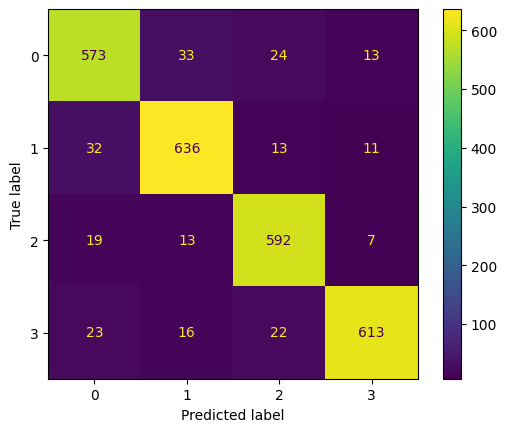

In [54]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model, xtest,ytest)

### Predict for train and test

In [55]:
ypred_train = model.predict(xtrain)
ypred_test = model.predict(xtest)

In [56]:
ypred_test[0:5]

array([0, 3, 2, 1, 1], dtype=int64)

In [57]:
ytest[0:5]

array([0, 3, 2, 1, 1])

In [58]:
from sklearn.metrics import classification_report
print(classification_report(ytest, ypred_test))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       643
           1       0.91      0.92      0.92       692
           2       0.91      0.94      0.92       631
           3       0.95      0.91      0.93       674

    accuracy                           0.91      2640
   macro avg       0.91      0.91      0.91      2640
weighted avg       0.91      0.91      0.91      2640



In [59]:
ypred_train_lab = le.inverse_transform(ypred_train)
ypred_test_lab = le.inverse_transform(ypred_test)

In [60]:
ypred_test_lab[0:5]

array(['Cloudy', 'Sunny', 'Snowy', 'Rainy', 'Rainy'], dtype=object)

### Out of Sample prediction 

In [61]:
xnew = pd.read_csv('test_weather.csv')
xnew.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location
0,0,68,16.0,66.0,overcast,984.94,0,Winter,2.0,mountain
1,107,107,15.0,83.0,partly cloudy,1015.00,11,Summer,7.0,mountain
2,19,76,12.5,35.0,partly cloudy,1017.26,4,Summer,8.0,inland
3,22,99,18.5,NaN,partly cloudy,1012.70,0,NaN,3.5,inland
4,33,25,8.0,6.0,partly cloudy,1023.77,6,Spring,NaN,inland


In [62]:
xnew_pre = pre.fit_transform(xnew)
xnew_pre.head()

,num__Temperature,num__Humidity,num__Wind Speed,num__Precipitation (%),num__Atmospheric Pressure,num__UV Index,num__Visibility (km),cat__Cloud Cover_clear,cat__Cloud Cover_cloudy,cat__Cloud Cover_overcast,cat__Cloud Cover_partly cloudy,cat__Season_Autumn,cat__Season_Spring,cat__Season_Summer,cat__Season_Winter,cat__Location_coastal,cat__Location_inland,cat__Location_mountain
0,-0.969243,-0.135952,0.451064,0.250031,-0.399453,-0.987235,-1.018831,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,4.722797,1.679842,0.339137,0.786714,0.404621,1.863051,0.608694,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.041493,0.236519,0.059321,-0.728626,0.465074,0.049232,0.934199,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.201083,1.307371,0.730880,0.092183,0.343098,-0.987235,-0.530573,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.786246,-2.137981,-0.444348,-1.644143,0.639209,0.567466,-0.367821,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [63]:
preds = model.predict(xnew_pre)
preds

array([2, 3, 0, 1, 3, 0, 2, 2, 2, 3, 1, 1, 2, 0, 3, 2, 0, 1, 3, 2, 1, 1,
       0, 1, 3, 2, 0, 0, 1, 2, 3, 0, 2, 1, 1, 0, 0, 0, 1, 2, 2, 1, 2, 2,
       0, 0, 2, 0, 2, 3, 3, 0, 1, 1, 3, 1, 3, 3, 1, 1, 3, 2, 3, 0, 2, 3,
       2, 0, 1, 2, 1, 1, 0, 0, 0, 3, 1, 1, 0, 0, 3, 2, 1, 1, 2, 2, 3, 0,
       0, 2, 3, 3, 2, 2, 3, 0, 1, 2, 3, 0], dtype=int64)

In [64]:
pred_lab = le.inverse_transform(preds)
pred_lab

array(['Snowy', 'Sunny', 'Cloudy', 'Rainy', 'Sunny', 'Cloudy', 'Snowy',
       'Snowy', 'Snowy', 'Sunny', 'Rainy', 'Rainy', 'Snowy', 'Cloudy',
       'Sunny', 'Snowy', 'Cloudy', 'Rainy', 'Sunny', 'Snowy', 'Rainy',
       'Rainy', 'Cloudy', 'Rainy', 'Sunny', 'Snowy', 'Cloudy', 'Cloudy',
       'Rainy', 'Snowy', 'Sunny', 'Cloudy', 'Snowy', 'Rainy', 'Rainy',
       'Cloudy', 'Cloudy', 'Cloudy', 'Rainy', 'Snowy', 'Snowy', 'Rainy',
       'Snowy', 'Snowy', 'Cloudy', 'Cloudy', 'Snowy', 'Cloudy', 'Snowy',
       'Sunny', 'Sunny', 'Cloudy', 'Rainy', 'Rainy', 'Sunny', 'Rainy',
       'Sunny', 'Sunny', 'Rainy', 'Rainy', 'Sunny', 'Snowy', 'Sunny',
       'Cloudy', 'Snowy', 'Sunny', 'Snowy', 'Cloudy', 'Rainy', 'Snowy',
       'Rainy', 'Rainy', 'Cloudy', 'Cloudy', 'Cloudy', 'Sunny', 'Rainy',
       'Rainy', 'Cloudy', 'Cloudy', 'Sunny', 'Snowy', 'Rainy', 'Rainy',
       'Snowy', 'Snowy', 'Sunny', 'Cloudy', 'Cloudy', 'Snowy', 'Sunny',
       'Sunny', 'Snowy', 'Snowy', 'Sunny', 'Cloudy', 'Rainy', 'Sno

In [66]:
probs =model.predict_proba(xnew_pre)
probs[0:5]

array([[3.65461718e-04, 2.69205379e-03, 9.96820807e-01, 1.21693425e-04],
       [1.04788318e-02, 1.10530795e-03, 1.48017367e-04, 9.88267839e-01],
       [5.23453414e-01, 6.53075147e-03, 1.40931392e-02, 4.55922723e-01],
       [2.21957583e-02, 9.70462739e-01, 1.55129994e-03, 5.79020707e-03],
       [1.08166679e-03, 2.14089072e-04, 3.01581901e-03, 9.95688379e-01]],
      dtype=float32)

In [67]:
import numpy as np
max_probs = np.max(probs, axis=1)
max_probs

array([0.9968208 , 0.98826784, 0.5234534 , 0.97046274, 0.9956884 ,
       0.98198307, 0.99473923, 0.9975036 , 0.96076804, 0.92030364,
       0.94603175, 0.9825204 , 0.9971403 , 0.8491326 , 0.9996779 ,
       0.8323799 , 0.98684144, 0.6208949 , 0.9894583 , 0.99824214,
       0.9594587 , 0.9821233 , 0.9949091 , 0.98764473, 0.38879055,
       0.9942736 , 0.98966277, 0.67801553, 0.8801252 , 0.940631  ,
       0.99991095, 0.9818475 , 0.9940382 , 0.7151252 , 0.9526215 ,
       0.9849252 , 0.50726265, 0.9788669 , 0.95865476, 0.32683963,
       0.99542147, 0.7637767 , 0.9702904 , 0.9953133 , 0.50266033,
       0.5001741 , 0.9420674 , 0.86272305, 0.9771762 , 0.9999722 ,
       0.99980146, 0.7489938 , 0.9895337 , 0.9510064 , 0.9994622 ,
       0.35574594, 0.9992536 , 0.32436156, 0.9894385 , 0.9506925 ,
       0.9992204 , 0.8627897 , 0.99996436, 0.33184627, 0.99688125,
       0.9993179 , 0.9970829 , 0.51908094, 0.9891858 , 0.98213094,
       0.98880625, 0.9911328 , 0.7088537 , 0.946755  , 0.96327

In [68]:
xnew['Weather_type_pred'] = pred_lab
xnew['probability'] = max_probs

In [69]:
xnew.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather_type_pred,probability
0,0,68,16.0,66.0,overcast,984.94,0,Winter,2.0,mountain,Snowy,0.996821
1,107,107,15.0,83.0,partly cloudy,1015.00,11,Summer,7.0,mountain,Sunny,0.988268
2,19,76,12.5,35.0,partly cloudy,1017.26,4,Summer,8.0,inland,Cloudy,0.523453
3,22,99,18.5,NaN,partly cloudy,1012.70,0,NaN,3.5,inland,Rainy,0.970463
4,33,25,8.0,6.0,partly cloudy,1023.77,6,Spring,NaN,inland,Sunny,0.995688


In [70]:
xnew.to_csv("xgbResults.csv", index=False)

In [71]:
model.feature_importances_

array([0.14443506, 0.00960321, 0.00780337, 0.05721187, 0.03124421,
       0.1579762 , 0.06865613, 0.3516626 , 0.01896339, 0.03920452,
       0.00960927, 0.00421309, 0.00492154, 0.0041902 , 0.07817777,
       0.00609042, 0.00261485, 0.00342233], dtype=float32)

In [72]:
imp = pd.Series(model.feature_importances_, index= xtrain.columns)
imp

num__Temperature                  0.144435
num__Humidity                     0.009603
num__Wind Speed                   0.007803
num__Precipitation (%)            0.057212
num__Atmospheric Pressure         0.031244
num__UV Index                     0.157976
num__Visibility (km)              0.068656
cat__Cloud Cover_clear            0.351663
cat__Cloud Cover_cloudy           0.018963
cat__Cloud Cover_overcast         0.039205
cat__Cloud Cover_partly cloudy    0.009609
cat__Season_Autumn                0.004213
cat__Season_Spring                0.004922
cat__Season_Summer                0.004190
cat__Season_Winter                0.078178
cat__Location_coastal             0.006090
cat__Location_inland              0.002615
cat__Location_mountain            0.003422
dtype: float32

In [73]:
imp.sort_values(ascending=False)

cat__Cloud Cover_clear            0.351663
num__UV Index                     0.157976
num__Temperature                  0.144435
cat__Season_Winter                0.078178
num__Visibility (km)              0.068656
num__Precipitation (%)            0.057212
cat__Cloud Cover_overcast         0.039205
num__Atmospheric Pressure         0.031244
cat__Cloud Cover_cloudy           0.018963
cat__Cloud Cover_partly cloudy    0.009609
num__Humidity                     0.009603
num__Wind Speed                   0.007803
cat__Location_coastal             0.006090
cat__Season_Spring                0.004922
cat__Season_Autumn                0.004213
cat__Season_Summer                0.004190
cat__Location_mountain            0.003422
cat__Location_inland              0.002615
dtype: float32

<Axes: >

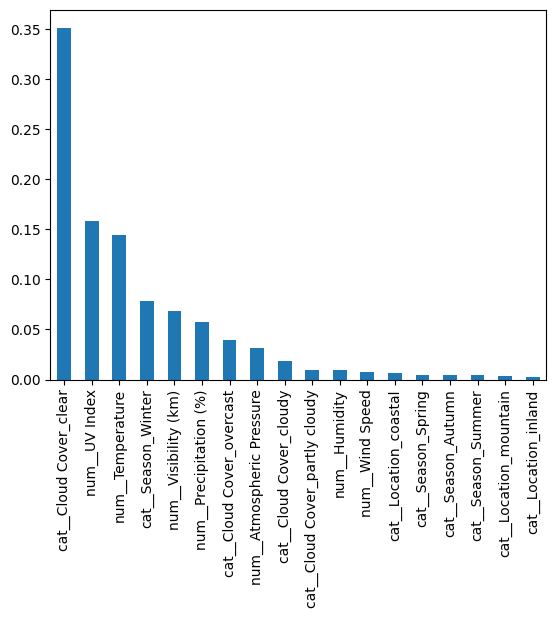

In [74]:
imp.sort_values(ascending=False).plot(kind='bar')